Importing libraries

In [ ]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip

Installing missing libraries

In [ ]:
!pip install ultralytics
from ultralytics import YOLO

!pip install gTTS
from gtts import gTTS
from IPython.display import Audio

Importing videos from Google Drive for easier access

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

color_video_path = '/content/drive/MyDrive/challenge_color_848x480.mp4'
depth_video_path = '/content/drive/MyDrive/challenge_depth_848x480.mp4'

# Verifying if the videos were correctly identified
print("Color exists:", os.path.exists(color_video_path))
print("Depth exists:", os.path.exists(depth_video_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Color exists: True
Depth exists: True


Extracting the frame that I'm going to use

In [ ]:
cap = cv2.VideoCapture(color_video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
print("FPS:", fps)

timestamp = 104  # seconds
frame_number = int(fps * timestamp)
print("Frame number at 1:41 -->", frame_number)
cap.release()


FPS: 30.0
Frame number at 1:41 --> 3120


Frames read successfully!


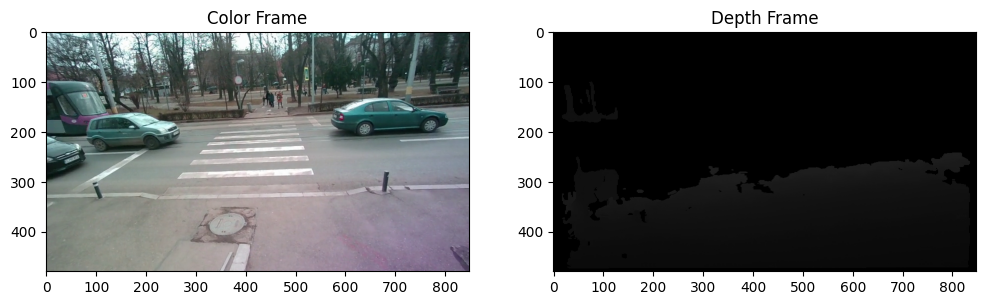

In [ ]:
# Reload videos
color_cap = cv2.VideoCapture(color_video_path)
depth_cap = cv2.VideoCapture(depth_video_path)

# Setting the selected frame
color_cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
depth_cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

# Read frames
ret_color, color_frame = color_cap.read()
ret_depth, depth_frame = depth_cap.read()

# Checking if the read was successful
if not ret_color or not ret_depth:
    print("Failed to read frame.")
else:
    print("Frames read successfully!")

    # Save to disk
    cv2.imwrite("color_frame.png", color_frame)
    cv2.imwrite("depth_frame.png", depth_frame)

    # Show preview of the frames
    from matplotlib import pyplot as plt

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(color_frame, cv2.COLOR_BGR2RGB))
    plt.title("Color Frame")

    plt.subplot(1,2,2)
    plt.imshow(depth_frame, cmap='gray')
    plt.title("Depth Frame")
    plt.show()

# Clean up
color_cap.release()
depth_cap.release()


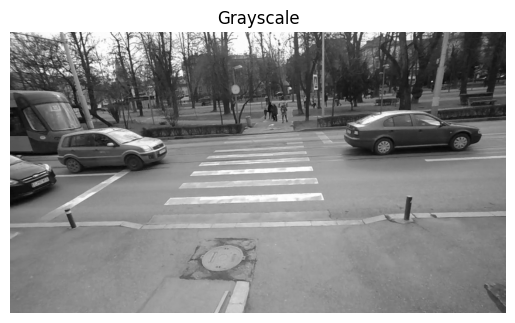

In [ ]:
# Load the color frame
img = cv2.imread("color_frame.png")

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Show preview
plt.imshow(gray, cmap='gray')
plt.title("Grayscale")
plt.axis('off')
plt.show()


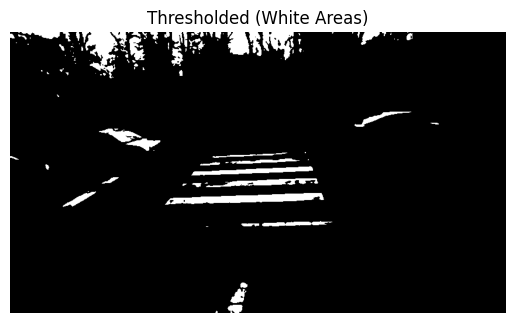

In [ ]:
# Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Threshold to isolate bright (white) areas
_, thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)

# Show preview
plt.imshow(thresh, cmap='gray')
plt.title("Thresholded (White Areas)")
plt.axis('off')
plt.show()


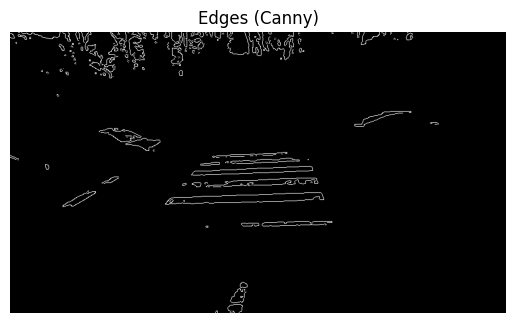

In [ ]:
# Using Canny to detect edges
edges = cv2.Canny(thresh, 50, 150)

plt.imshow(edges, cmap='gray')
plt.title("Edges (Canny)")
plt.axis('off')
plt.show()


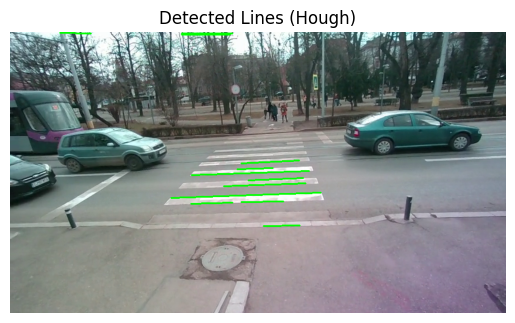

In [ ]:
# Creating a copy for line printing
line_img = img.copy()

# Detect lines
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=80,
                        minLineLength=50, maxLineGap=10)

# Draw lines if any found
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    tts = gTTS(text="Crosswalk detected", lang='en')
    tts.save("crosswalk.mp3")
    display(Audio("crosswalk.mp3", autoplay=True))
else:
    tts = gTTS(text="Crosswalk not detected", lang='en')
    tts.save("no_crosswalk.mp3")
    display(Audio("no_crosswalk.mp3", autoplay=True))

# Show preview of the detected lines
plt.imshow(cv2.cvtColor(line_img, cv2.COLOR_BGR2RGB))
plt.title("Detected Lines (Hough)")
plt.axis('off')
plt.show()




0: 384x640 3 persons, 3 cars, 1 bus, 306.4ms
Speed: 2.8ms preprocess, 306.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


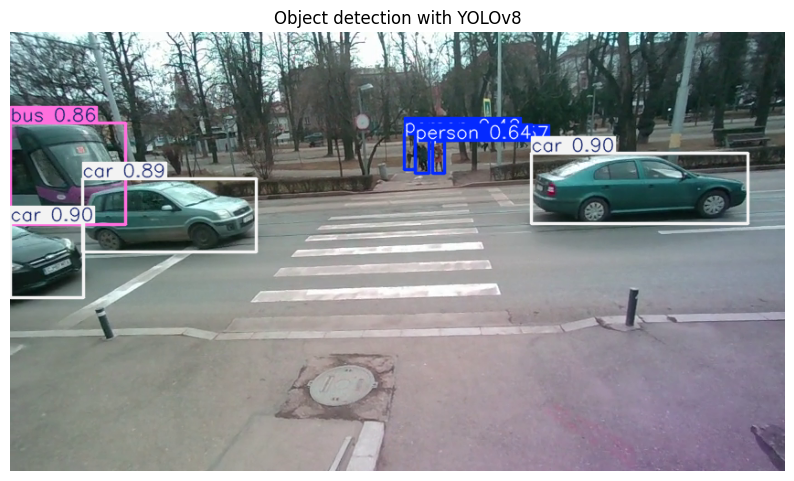

In [ ]:
img_path = "color_frame.png"
img = cv2.imread(img_path)

# Load YOLOv8 model
model = YOLO('yolov8s.pt')

# Run detection
results = model(img)

vehicle_classes = ['car', 'bus', 'truck', 'motorcycle', 'train', 'tram']

# Draw detections
annotated_frame = results[0].plot()

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
plt.title("Object detection with YOLOv8")
plt.axis('off')
plt.show()


In [ ]:
detections = results[0].boxes.data.cpu().numpy()
names = results[0].names

# Count objects
object_counts = {}

for det in detections:
    class_id = int(det[5])
    class_name = names[class_id]

    # Keep only things that are useful for me
    if class_name in ['person', 'car', 'bus', 'truck', 'motorcycle', 'bicycle']:
        if class_name not in object_counts:
            object_counts[class_name] = 1
        else:
            object_counts[class_name] += 1

# Crosswalk check (did we detect enough lines?)
crosswalk_present = lines is not None and len(lines) > 3

# Compose description
descriptions = []

if crosswalk_present:
    descriptions.append("Crosswalk ahead")

for obj, count in object_counts.items():
    if count == 1:
        descriptions.append(f"One {obj} ahead")
    else:
        descriptions.append(f"{count} {obj}s ahead")

# Final sentence
full_description = ". ".join(descriptions) + "."

print("Description:", full_description)


Description: Crosswalk ahead. 3 cars ahead. One bus ahead. 3 persons ahead.


In [ ]:
# Convert to speech
tts = gTTS(text=full_description, lang='en')
tts.save("description.mp3")

Audio("description.mp3", autoplay=True)


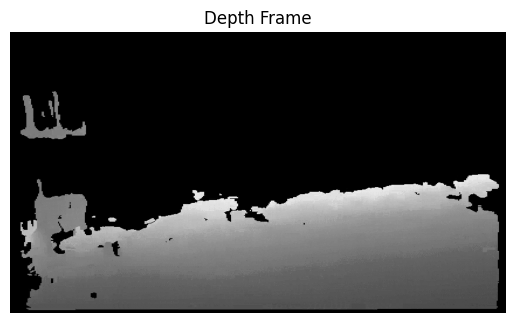

In [ ]:
depth_gray = cv2.cvtColor(depth_frame, cv2.COLOR_BGR2GRAY)

# Show depth frame
plt.imshow(depth_gray, cmap='gray')
plt.title("Depth Frame")
plt.axis('off')
plt.show()

In [ ]:
def get_distance_from_depth(depth_img, bbox):
    x1, y1, x2, y2 = bbox.astype(int)
    cx = (x1 + x2) // 2
    cy = (y1 + y2) // 2

    # Get depth value at center of bbox
    depth_value = depth_img[cy, cx]

    distance_m = (depth_value / 255.0) * 5.0
    return round(distance_m, 2), (cx, cy)


In [ ]:
distances = []

for det in detections:
    x1, y1, x2, y2, conf, class_id = det
    class_id = int(class_id)
    class_name = names[class_id]

    if class_name in ['person', 'car', 'bus', 'truck', 'motorcycle']:
        distance, (cx, cy) = get_distance_from_depth(depth_gray, np.array([x1, y1, x2, y2]))
        distances.append((class_name, distance))
        cv2.circle(img, (cx, cy), 5, (0, 0, 255), -1)
        cv2.putText(img, f"{class_name} - {distance}m", (cx, cy - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)


In [ ]:
if lines is not None:
    y_positions = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        y_positions.append((y1 + y2) // 2)

    avg_y = int(np.mean(y_positions))
    avg_x = depth_gray.shape[1] // 2

    crosswalk_depth = depth_gray[avg_y, avg_x]
    crosswalk_distance = (crosswalk_depth / 255.0) * 5.0
    crosswalk_distance = round(crosswalk_distance, 2)

    cv2.circle(img, (avg_x, avg_y), 5, (255, 0, 0), -1)
    cv2.putText(img, f"Crosswalk - {crosswalk_distance}m", (avg_x, avg_y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)


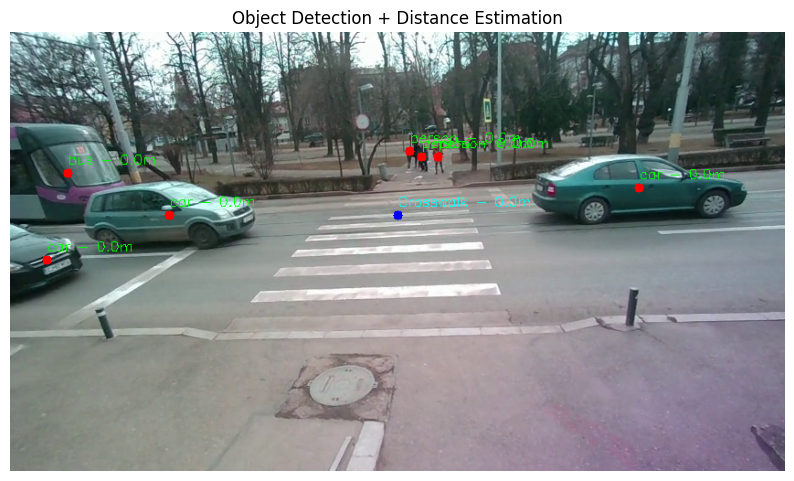

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Object Detection + Distance Estimation")
plt.axis('off')
plt.show()
